# Testing DEMV on _Communities&Crime_ (CRIME) dataset

Data source: [https://archive.ics.uci.edu/ml/datasets/communities+and+crime](https://archive.ics.uci.edu/ml/datasets/communities+and+crime)

- Unprivileged group: `black_people=1 && hisp_people=1`
- Positive label: 100

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [2]:
def prepare_data():
  '''Load the data and apply some pre-processing steps'''
  
  data = pd.read_excel('data2/crime_data_normalized.xlsx', na_values='?')
  data.drop(['state', 'county', 'community', 'communityname',
            'fold', 'OtherPerCap'], axis=1, inplace=True)
  na_cols = data.isna().any()[data.isna().any() == True].index
  data.drop(na_cols, axis=1, inplace=True)
  data = (data - data.mean())/data.std()
  y_classes = np.quantile(data['ViolentCrimesPerPop'].values, [
                          0, 0.2, 0.4, 0.6, 0.8, 1])
  i = 0
  data['ViolentCrimesClass'] = data['ViolentCrimesPerPop']
  for cl in y_classes:
    data.loc[data['ViolentCrimesClass'] <= cl, 'ViolentCrimesClass'] = i*100
    i += 1
  data.drop('ViolentCrimesPerPop', axis=1, inplace=True)
  data['black_people'] = data['racepctblack'] > -0.45
  data['hisp_people'] = data['racePctHisp'] > -0.4
  data['black_people'] = data['black_people'].astype(int)
  data['hisp_people'] = data['hisp_people'].astype(int)
  data.drop('racepctblack', axis=1, inplace=True)
  data.drop('racePctHisp', axis=1, inplace=True)
  return data


In [3]:
data = prepare_data()

In [15]:
data

,population,householdsize,racePctWhite,racePctAsian,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,...,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesClass,black_people,hisp_people
0,1.043350,-0.814793,0.599427,-0.161248,-0.542654,-0.166244,-0.277853,-0.575741,1.059815,0.682833,...,-0.193271,-0.580608,-0.058165,0.500363,0.133666,0.167274,0.940163,300.0,0,1
1,-0.453823,-1.853172,-0.056205,1.418626,-1.058133,0.669623,0.082497,-0.854782,-0.343627,0.682833,...,-1.075534,-0.131778,-0.663550,-0.413220,-0.555677,1.258716,-0.391349,500.0,1,1
2,-0.453823,-0.265063,-0.793790,0.078127,-0.220481,-0.166244,-0.337911,-0.575741,-0.499564,-1.565315,...,0.027294,0.217312,-0.461755,-0.504578,-0.112528,-0.618564,-0.391349,500.0,1,0
3,-0.138629,1.872776,-2.760686,-0.161248,0.552737,0.042723,0.022439,-1.189630,-0.031751,0.682833,...,1.074981,0.067702,-0.007717,-0.413220,0.773770,0.516536,-0.391349,300.0,1,1
4,-0.375024,0.528992,0.804312,-0.304873,-0.284915,-0.793144,-0.638204,-0.352509,-0.343627,0.458018,...,0.578708,-0.081908,-0.613101,-0.230503,-0.703394,-0.618564,-0.391349,100.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,-0.375024,-0.387225,0.476496,-0.161248,0.037258,0.112378,0.082497,-0.687357,-0.265658,0.682833,...,-1.075534,-0.730218,-1.319383,-0.504578,0.232143,-0.487591,-0.391349,200.0,1,1
1990,-0.059830,3.033317,-1.941146,3.237874,1.712562,2.550324,2.364717,-1.580287,-0.031751,0.682833,...,-2.012937,-2.625277,-3.286882,-0.413220,0.675293,0.167274,-0.391349,500.0,1,1
1991,0.806954,-0.570468,-0.261090,-0.544248,-0.478220,0.042723,-0.157736,0.652037,0.825908,0.682833,...,0.413284,0.815752,0.547219,0.134930,0.429099,0.079959,3.395139,400.0,1,1
1992,0.176566,0.284667,0.476496,0.317502,1.003780,1.714457,1.764133,-0.073469,0.202156,0.682833,...,0.027294,-0.181648,-0.663550,-0.321862,0.724532,0.734824,0.524066,300.0,0,1


In [4]:
label = 'ViolentCrimesClass'
groups_condition = {'black_people': 1, 'hisp_people': 1}
sensitive_features = ['black_people', 'hisp_people']
positive_label = 100

In [5]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(n_jobs=-1))
])

## Logistic Regression Bias

In [18]:
model, lr_bias = cross_val(pipeline, data, label, groups_condition, sensitive_features, positive_label=positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [19]:
print_metrics(lr_bias)

Statistical parity:  -0.339  +-  0.048
Disparate impact:  0.09  +-  0.063
Zero one loss:  0.209  +-  0.067
F1 score:  0.487  +-  0.03
Accuracy score:  0.497  +-  0.027


## DEMV application

In [20]:
demv = DEMV(round_level=1)
demv_data = data.copy()

### Logistic regression DEMV

In [21]:
model, lr_demv = cross_val(pipeline, demv_data, label, groups_condition, sensitive_features, debiaser=demv, positive_label=100)
print_metrics(lr_demv)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Statistical parity:  -0.202  +-  0.055
Disparate impact:  0.367  +-  0.151
Zero one loss:  0.16  +-  0.063
F1 score:  0.437  +-  0.037
Accuracy score:  0.444  +-  0.035


In [22]:
print_metrics(lr_demv)

Statistical parity:  -0.202  +-  0.055
Disparate impact:  0.367  +-  0.151
Zero one loss:  0.16  +-  0.063
F1 score:  0.437  +-  0.037
Accuracy score:  0.444  +-  0.035


## DEMV Evaluation

In [23]:
demv.get_iters()

164

In [24]:
metrics = eval_demv(42, 164, data.copy(), pipeline, label, groups_condition, sensitive_features, positive_label=100)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

##  Blackbox Postprocessing

In [6]:
data = data.sample(frac=1).reset_index(drop=True)

In [7]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, groups_condition, sensitive_features, positive_label=positive_label)


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.3133  0.7000
200.0  0.0510  0.1600
300.0  0.2020  0.3750
400.0  0.0648  0.2000
500.0  0.0769  0.6842

1
          fpr     tpr
100.0  0.0435  0.2500
200.0  0.1143  0.2857
300.0  0.2830  0.4167
400.0  0.1897  0.3684
500.0  0.0862  0.7368


And loss is 0.5400


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.3289  0.7500
200.0  0.0333  0.1364
300.0  0.2000  0.4091
400.0  0.0510  0.2143
500.0  0.0638  0.7222

1
          fpr     tpr
100.0  0.0333  0.2500
200.0  0.1311  0.2857
300.0  0.2553  0.3810
400.0  0.1852  0.3571
500.0  0.1000  0.7778


And loss is 0.5222

[0.67691155 0.11938554 0.04041279 0.14721267 0.01607744]
[6.56399081e-01 1.98140582e-01 2.34920101e-02 1.21968328e-01
 7.01463114e-13]
[0.32819954 0.07794679 0.10876804 0.34266138 0.14242424]
[0.06446777 0.00802055 0.16409177 0.35714286 0.40627706]
[5.72865459e-13 7.84067978e-04 7.55138035e-02 1.45924351e-01
 7.77777778e-01]
[6.76911552e-01 6.93492

##  Plot

In [8]:
df = prepareplots(metrics,'crime')

NameError: name 'metrics' is not defined

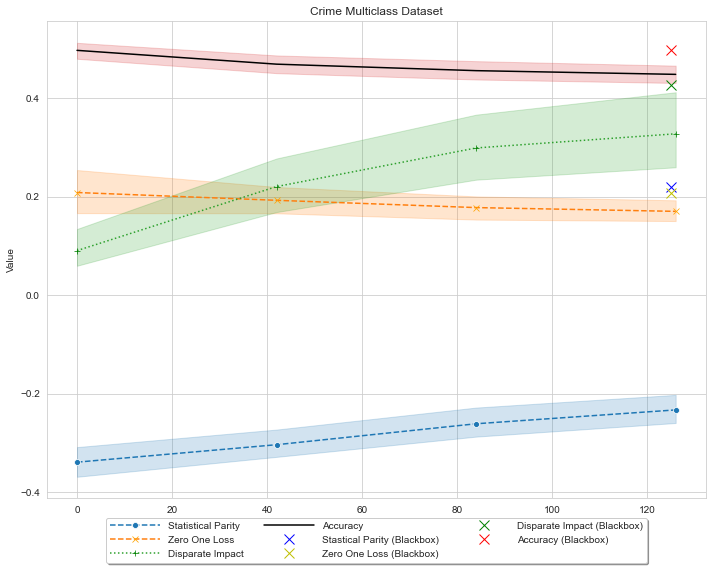

In [28]:
points = preparepoints(blackboxmetrics, 125)

plot_metrics_curves(df, points, title='Crime Multiclass Dataset')


In [29]:
unprivpergentage(data,groups_condition, demv.get_iters())

Dataset size: 1994
Unprivileged group size: 471
Percentage of unprivileged group: 23.620862587763288
Number of iterations: 164


In [30]:
save_metrics('blackbox', 'crime', blackboxmetrics)